In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os.path import join

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import sys
# from tqdm.notebook import tqdm #display progress bars
import torchvision.transforms as T
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Icons(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) #Sets up the dataset using ImageFolder and applies any specified transformations.


    def __len__(self):
        return len(self.data) #Returns the number of images in the dataset.


    def __getitem__(self, idx):
        return self.data[idx] # Retrieves the image and label for a given index.


    @property  #@property: Turns a method into a read-only attribute.
    def classes(self):
        return self.data.classes  #Provides the list of class names.

transform =  transforms.Compose([
    transforms.Resize((64, 64)),  # Resizes each image to 64x64 pixels
    transforms.ToTensor() # Converts the image to a PyTorch tensor and normalizes the pixel values to the range [0, 1].
])
show_img_transform = T.ToPILImage()

class_label_dict = {0: 'anchor',
                    1: 'apple', 
                    2: 'bird', 
                    3: 'bomb',
                    4: 'bottle', 
                    5: 'cactus', 
                    6: 'candle', 
                    7: 'car', 
                    8: 'carrot', 
                    9: 'cat', 
                    10: 'cheese', 
                    11: 'clock',
                    12: 'clover', 
                    13: 'clown',
                    14: 'daisy', 
                    15: 'dinosaur', 
                    16: 'do_not_enter', 
                    17: 'dog', 
                    18: 'dolphin', 
                    19: 'dragon', 
                    20: 'droplet', 
                    21: 'exclamation', 
                    22: 'eye', 
                    23: 'fire', 
                    24: 'ghost', 
                    25: 'hand', 
                    26: 'heart', 
                    27: 'ice', 
                    28: 'igloo', 
                    29: 'key', 
                    30: 'knight', 
                    31: 'ladybug', 
                    32: 'leaf', 
                    33: 'lightbulb', 
                    34: 'lightning', 
                    35: 'lips', 
                    36: 'lock', 
                    37: 'mallet', 
                    38: 'man', 
                    39: 'moon',
                    40: 'pencil', 
                    41: 'question', 
                    42: 'scissors', 
                    43: 'skull', 
                    44: 'snowflake', 
                    45: 'snowman', 
                    46: 'spider', 
                    47: 'splat', 
                    48: 'sun', 
                    49: 'sunglasses', 
                    50: 'target', 
                    51: 'treble', 
                    52: 'tree', 
                    53: 'turtle', 
                    54: 'web', 
                    55: 'yin_yang', 
                    56: 'zebra'}

##### Create Data

Training Data Length: 1957
Class: cactus


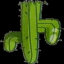

In [3]:
training_data = Icons(join("data", "train"), transform)
# training_data_64 = Icons('data/train', transform)
test_data = Icons(join("data", "test"), transform)
print(f"Training Data Length: {len(training_data)}")
image, label = training_data[200]
label = class_label_dict[label]
print(f"Class: {label}")
display(show_img_transform(image))

##### Load Data Into DataLoader

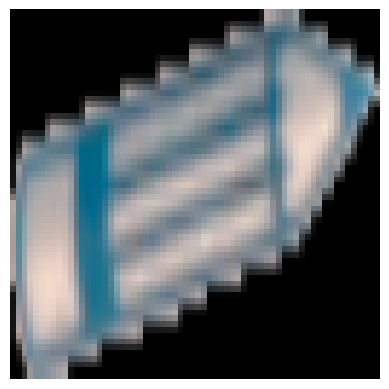

Label: pencil
64x64 Image




In [4]:
batch_size_input = 32

train_loader= DataLoader(training_data, batch_size=batch_size_input, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_input, shuffle=False)

# Display image and label
train_features, train_labels = next(iter(train_loader))
img = train_features[0].squeeze()
label = train_labels[0]
# Permute the dimensions of the image tensor to (128, 128, 3)
img = img.permute(1, 2, 0)
plt.imshow(img, cmap="gray")
plt.axis('off')  # Optional: Hide the axis ticks and labels
plt.show()
plt.show()
label = class_label_dict[int(label)]
print(f"Label: {label}")
print("64x64 Image")
print("\n")

##### Model

In [5]:
class CNN1(nn.Module):
  # based off the GT/Oregon State Visual
  def __init__(self,num_classes=len(class_label_dict)):
    super(CNN1, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Defines a max pooling layer
    self.conv3 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
    self.fc1 = nn.Linear(16*16*16, num_classes)
  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.pool(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.conv4(x)
    x = self.relu(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)  # Flatten the tensor
    x = self.fc1(x)
    return x


In [6]:
model = CNN1(num_classes=len(class_label_dict))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
# Lists to store training and test losses
train_losses = []
test_losses = []

num_epochs = 50

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Loop through training data
    #print("Epoch: " + str(epoch + 1))
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    # Average training loss for the epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()  # Set model to evaluation mode
    running_test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  #
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

    # Average test loss for the epoch
    avg_test_loss = running_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

# Save the model's state_dict
torch.save(model.state_dict(), "model_weights.pth")  # Replace "model_weights.pth" with your desired file name
print("Model weights saved successfully!")

Model weights saved successfully!


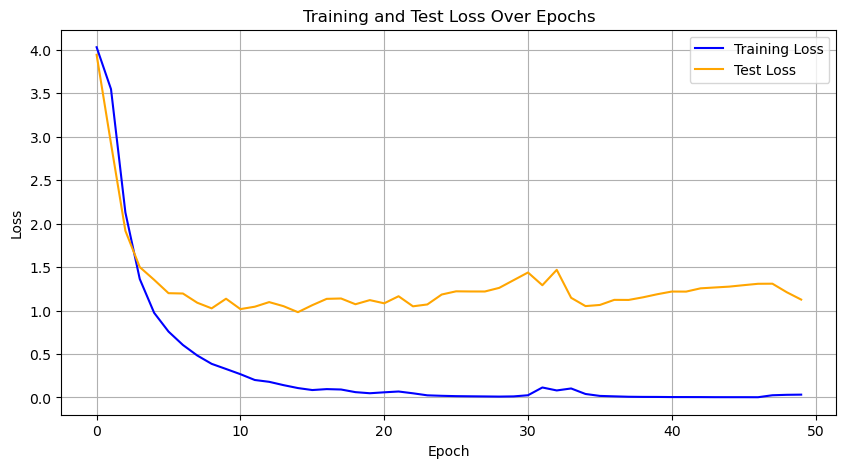

In [7]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='orange')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

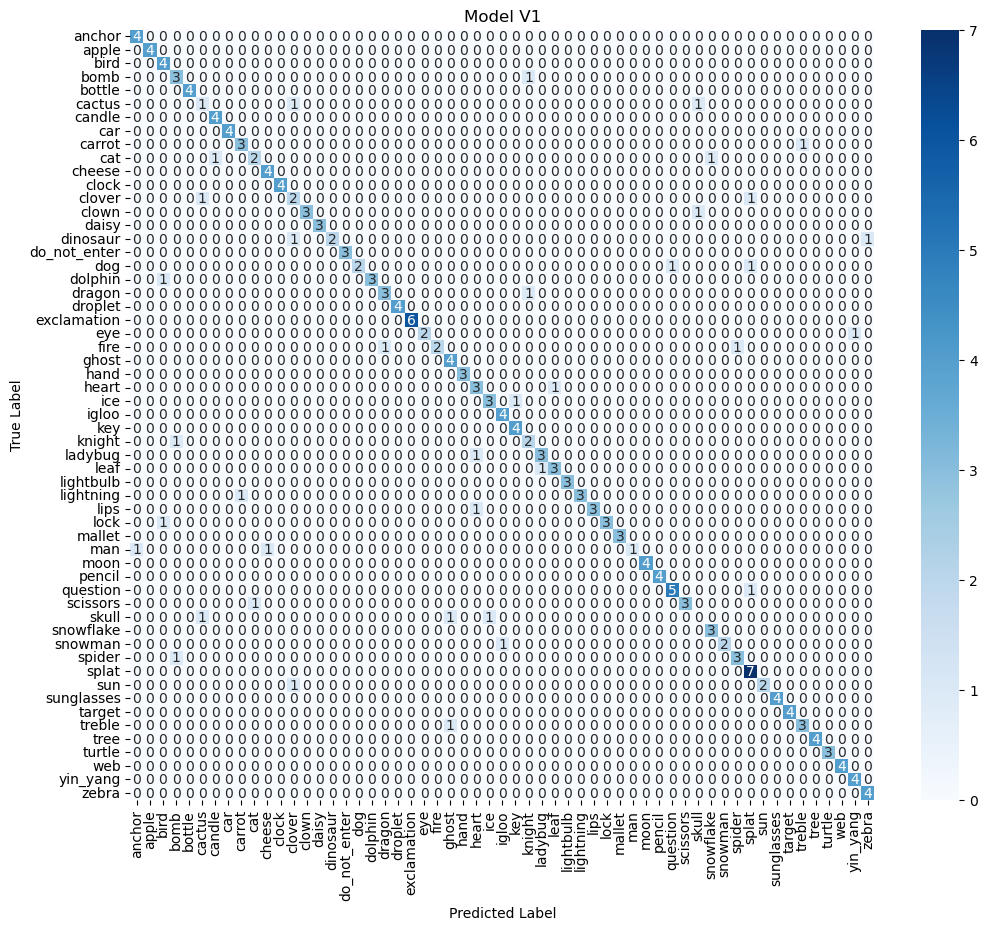

In [18]:
symbol_list = [
    'anchor', 'apple', 'bird', 'bomb', 'bottle', 'cactus', 
    'candle', 'car', 'carrot', 'cat', 'cheese', 'clock', 
    'clover', 'clown', 'daisy', 'dinosaur', 'do_not_enter', 
    'dog', 'dolphin', 'dragon', 'droplet', 'exclamation', 'eye', 
    'fire', 'ghost', 'hand', 'heart', 'ice', 'igloo', 'key', 
    'knight', 'ladybug', 'leaf', 'lightbulb', 'lightning', 
    'lips', 'lock', 'mallet', 'man', 'moon', 'pencil', 
    'question', 'scissors', 'skull', 'snowflake', 'snowman', 
    'spider', 'splat', 'sun', 'sunglasses', 'target', 'treble', 
    'tree', 'turtle', 'web', 'yin_yang', 'zebra'
    ]
label_mapping = {name: idx for idx, name in enumerate(symbol_list)}

def calculate_confusion_matrix(predictions, gt_labels, num_classes):
    """
    Calculate the confusion matrix based on predictions and ground truth labels.

    Args:
        predictions (list): List of predicted labels.
        gt_labels (list): List of ground truth labels.
        num_classes (int): The number of classes/labels.

    Returns:
        list: A 2D list representing the confusion matrix.
    """
    # Initialize the confusion matrix with zeros
    # The matrix is a 2D list where rows represent the true classes/labels
    # and columns represent the predicted classes/labels
    confusion_matrix = [[0 for _ in range(num_classes)]
                        for _ in range(num_classes)]

    # Iterate over the pairs of predictions and ground truth labels
    for pred, true in zip(predictions, gt_labels):
        confusion_matrix[true][pred] += 1

    # Return the populated confusion matrix
    return confusion_matrix

def get_predictions_and_labels(model, loader):
    """
    Get predictions and ground truth labels from the model using the data loader.

    Args:
        model (torch.nn.Module): The trained model for making predictions.
        loader (DataLoader): The data loader providing test data in batches.

    Returns:
        tuple: A tuple containing two lists:
            - all_predictions (list): List of predicted labels.
            - all_labels (list): List of ground truth labels.
    """
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model.cpu()(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

for i, model in enumerate([model]):
    predictions, gt_labels = get_predictions_and_labels(model, test_loader)

    gt_indices = [label_mapping[symbol_list[label]] for label in gt_labels]
    pred_indices = [label_mapping[symbol_list[label]] for label in predictions]

    # Calculate confusion matrix with reordered indices
    cards_cm = calculate_confusion_matrix(pred_indices, gt_indices, 57)

    # Plotting the confusion matrix with ordered labels
    plt.figure(figsize=(12, 10))
    sns.heatmap(cards_cm, annot=True, fmt='d', cmap='Blues', vmin=0,
                xticklabels=symbol_list,
                yticklabels=symbol_list)
    plt.title(f'Model V{i+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("\n")

In [28]:
from PIL import Image
# Load and preprocess the image
# image_path = join("data", "validation", "car", "card55_01_contour_9.png")
image_path = join("data", "test", "splat", "card02_01_contour_1.png")   # I think it's an issue with this code, not the model

image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
image_tensor = transform(image).unsqueeze(0)

# Define and load the model
model = CNN1(num_classes=len(class_label_dict))
model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
model.eval()

# Predict the label
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_label = torch.max(outputs, 1)


display(image)
print(f"Predicted Class: {class_label_dict[predicted_label.item()]}")

Predicted Class: splat


There are 9 objects detected on card05_01.tif, with a minimum size of 194.0
The threshold area is 127.89375000000003


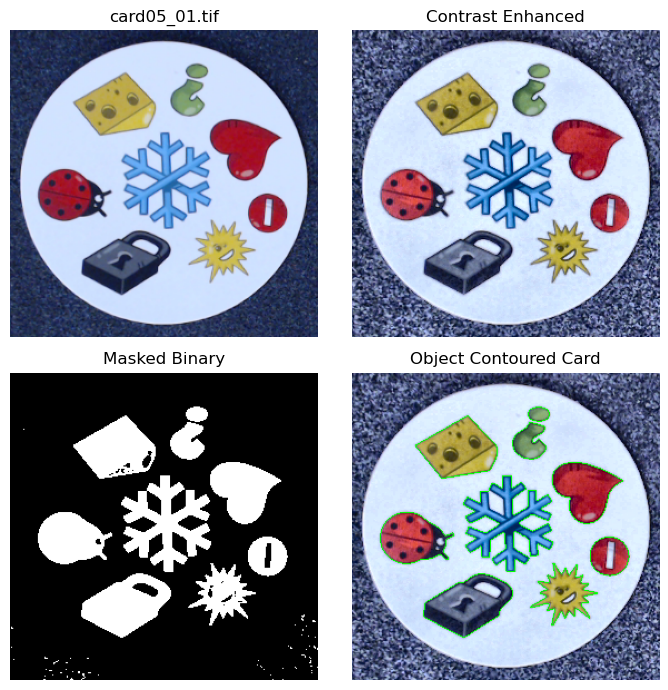

{'lock', 'question', 'snowflake', 'sun', 'heart', 'cheese', 'ladybug', 'do_not_enter'}


In [57]:
import cv2

def contrast_enhancement(img, clipLimit):
  """
  Converts input image into a contrast enhanced version by
  converting the image into the LAB color space, applying
  contrast limited adaptive histogram equalization with a 
  clip limit parameter to the lightness channel of LAB. This 
  effectively darkens the image while retaining the other data.

  Args:
    img: a 3D array with BGR image data
    clipLimit: a float **** lowkey i do not know what clipLimit is ****
  Returns:
    A contrast enhanced 3D array with RGB image data
  """
  # converting to LAB color space
  lab= cv2.cvtColor(img.copy(), cv2.COLOR_BGR2LAB)
  l_channel, a, b = cv2.split(lab)

  # Applying CLAHE to L-channel
  clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(8,8))
  cl = clahe.apply(l_channel)

  # merge the CLAHE enhanced L-channel with the a and b channel
  limg = cv2.merge((cl,a,b))
  enhanced_RGB = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

  return enhanced_RGB

def find_object_contours(img, sym_card_size_ratio, binary_threshold):
  """
  Takes a card image and finds the outermost contours above a certain area
  threshold excluding the card itself.

  Args:
    img: the image itself, as an openCV output. 3D array with 3 color channels
    sym_card_size_ratio: a float which controls the min size a symbol has to be 
      to qualify as an object. for example, 1/20 would mean the symbol is 1/20th 
      the size of the full card (this could be wrong lol)
    binary_threshold: an integer binary threshold for the conversion to a binary 
      image from a grayscaled version of img
  Returns:
    card_mask: a 2D black and white numpy array, where 255 is white and 0 is black.
      intended to be the filled in outline of the card (basically a circle)
    masked_binary: a 2D black and white numpy array, where 255 is white and 0 is black.
      intended to contain the just the objects on a black background
    object_contours: a list of contours which exceed the area threshold and are the
      the direct children of the card outline
  """
  gray_enhanced = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  _, binary= cv2.threshold(gray_enhanced, binary_threshold, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # create a mask to exclude the card
  card_mask = np.ones_like(gray_enhanced, dtype=np.uint8) * 255  # Start with a white mask
  card_contour = max(contours, key=cv2.contourArea)
  cv2.drawContours(card_mask, [card_contour], -1, color=0, thickness=cv2.FILLED)

  # Here we calculate the min required symbol size for size thresholding. With 1/20 for deck 2, 
  # this also removes the little lines coming off the bomb and some sections of the smaller splats
  threshold_area = cv2.contourArea(card_contour)*(sym_card_size_ratio**2)

  # apply the mask to the binary image
  masked_binary = cv2.bitwise_not(binary, binary, mask=card_mask)
  masked_binary = cv2.bitwise_not(masked_binary)
  outer_contours, _ = cv2.findContours(masked_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # area thresholding
  object_contours = [
     contour for contour in outer_contours if cv2.contourArea(contour) > threshold_area
     ]

  return [card_mask, masked_binary, object_contours, threshold_area]

file = 'card05_01.tif'
image = cv2.imread(file)
# enhance the contrast in the lightness color space
enhanced_RGB = contrast_enhancement(image, 4.0)

# draw the smaller contours for visualization
sym_card_size_ratio = 1/20
[card_mask, masked_binary, object_contours, threshold_area
  ] = find_object_contours(enhanced_RGB.copy(), sym_card_size_ratio, 180)
contoured_output_image = enhanced_RGB.copy()
cv2.drawContours(contoured_output_image, object_contours, -1, (0, 255, 0), thickness=1)

contour_areas = [cv2.contourArea(contour) for contour in object_contours]
print(f"There are {len(object_contours)} objects detected on {file}, with a minimum size of {min(contour_areas)}")
print(f"The threshold area is {threshold_area}")

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
axs[0,0].imshow(image_rgb)
axs[0,0].set_title(file)
axs[0,0].axis("off")

axs[0,1].imshow(enhanced_RGB, cmap="gray")
axs[0,1].set_title(f'Contrast Enhanced')
axs[0,1].axis("off")

axs[1,0].imshow(masked_binary, cmap="gray")
axs[1,0].set_title(f"Masked Binary")
axs[1,0].axis("off")

axs[1,1].imshow(contoured_output_image, cmap="gray")
axs[1,1].set_title(f'Object Contoured Card')
axs[1,1].axis("off")

plt.tight_layout()
plt.show()

icons = []
for i, contour in enumerate(object_contours):
  x, y, w, h = cv2.boundingRect(contour)
  # Crop the ROI from the original image
  roi = enhanced_RGB[y:y+h, x:x+w]
  mask = np.zeros((h, w), dtype=np.uint8)
  cv2.drawContours(mask, [contour - [x, y]], -1, 255, thickness=cv2.FILLED)
  roi_masked = cv2.bitwise_and(roi, roi, mask=mask)
  # Convert to BGRA (add alpha channel)
  roi_bgra = cv2.cvtColor(roi_masked, cv2.COLOR_RGB2BGRA)
  roi_bgra[:, :, 3] = mask  # Set alpha channel based on the mask
  roi_rgb = cv2.cvtColor(roi_bgra, cv2.COLOR_BGRA2RGB)
  icons.append(roi_rgb)
  # # Save the ROI as a PNG with transparency
  # contour_filename = f"{file.split('.')[0]}_contour_{i+1}.png"
  # contour_path = os.path.join(output_directory, contour_filename)
  # cv2.imwrite(contour_path, roi_bgra)
  # print(f"Saved transparent contour {i+1} to {contour_path}")

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
model = CNN1(num_classes=len(class_label_dict))
model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
model.eval()
icon_names = set()
for icon in icons: 
  image = Image.fromarray(icon).convert("RGB")
  # image = Image.open(image_path).convert("RGB")
  image_tensor = transform(image).unsqueeze(0)

  # Predict the label
  with torch.no_grad():
      outputs = model(image_tensor)
      _, predicted_label = torch.max(outputs, 1)
  icon_names.add(class_label_dict[predicted_label.item()])
print(icon_names)